# Introduction

This notebook should use torchvision and torch versions that are compatible with each other. For more information, visit [this link](https://pypi.org/project/torchvision/).

For demonstration purposes, we use the torch version 1.12.1 and the torchvision 0.13.1. However, users may install and use other versions.
We will also use Weights and Biases (Wandb) for visualizing log information in a nice way. You need to register and use your credentials.
- For registration: https://wandb.ai
- Tutorial about wandb: https://wandb.ai/site/tutorials
- Download the version 0.9.7 of wandb

In [1]:
#shell commands
#create a conda environment (or activate the env azureml_py38_PT_TF)
#pip install torch==1.12.1 
#pip install torchvision==0.13.1
#pip install wandb==0.9.7 #The latest version gives an PipeBroken error if run after Pytorch!

In [1]:
#Env: azureml_py38_PT_TF
import torch
import torchvision
print('The version of PyTorch is {}'.format(torch.__version__))
print('The version of Torchvision is {}'.format(torchvision.__version__))
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Used device is {}'.format(device))

/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
torch.cuda.device_count()

1

In [20]:
device

'cuda'

In [21]:
import wandb
import os
wandb.init(project="faster_rcnn_camera", entity="nasserai")

wandb: Wandb version 0.13.5 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


W&B Run: https://app.wandb.ai/nasserai/faster_rcnn_camera/runs/1ze6rrrh

Run pip install nbformat to save notebook history


In [5]:
os.environ['WANDB_NOTEBOOK_NAME'] = 'train.ipynb'
os.environ['PYTORCH_NO_CUDA_MEMORY_CACHING'] = '1' #To disable Pytorch caching

In [2]:
def memory_report():
    ma      = torch.cuda.memory_allocated()/(1024*1024*1024)
    max_ma  = torch.cuda.max_memory_allocated()/(1024*1024*1024)
    mr      = torch.cuda.memory_reserved()/(1024*1024*1024)
    max_mr  = torch.cuda.max_memory_reserved()/(1024*1024*1024)

    print('Memory allocated by PyTorch is {}'.format(ma))
    print('Maximum Memory allocated by PyTorch is {}'.format(max_ma))
    print('Memory reserved by PyTorch is {}'.format(mr))
    print('Maximum Memory reserved by PyTorch is {}'.format(max_mr))

    #Sometimes, this might need to be executed to free some memory (but needs a bit of time to reflect on the memory, so do not expect
    #that running the code afterward would work instantaneousely.)
    torch.cuda.memory_stats()
    torch.cuda.empty_cache() 

In [7]:
#torch.cuda.memory_stats()
memory_report()

Memory allocated by PyTorch is 0.0
Maximum Memory allocated by PyTorch is 0.0
Memory reserved by PyTorch is 0.0
Maximum Memory reserved by PyTorch is 0.0


In [3]:
#Imports
import json, os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2


from tqdm import tqdm
from matplotlib.patches import Rectangle
from PIL import Image

from torch_snippets import *

from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset

from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor


In [5]:
#Downloading the data from Azure data store
# azureml-core of version 1.0.72 or higher is required

'''
from azureml.core import Workspace, Dataset

subscription_id = '78b4d5f1-fca5-4af5-b686-34747c61c20f'
resource_group = 'computer_vision_resource_group'
workspace_name = 'computer_vision_workspace'

workspace = Workspace(subscription_id, resource_group, workspace_name)

dataset = Dataset.get_by_name(workspace, name='rumex_from_labelBox')
dataset.download(target_path='../data', overwrite=False)
'''


"\nfrom azureml.core import Workspace, Dataset\n\nsubscription_id = '78b4d5f1-fca5-4af5-b686-34747c61c20f'\nresource_group = 'computer_vision_resource_group'\nworkspace_name = 'computer_vision_workspace'\n\nworkspace = Workspace(subscription_id, resource_group, workspace_name)\n\ndataset = Dataset.get_by_name(workspace, name='rumex_from_labelBox')\ndataset.download(target_path='../data', overwrite=False)\n"

In [4]:
#Defining some link we will need later
home = os.path.join(os.path.expanduser('~'), 'cloudfiles/code/Users/roland.nasser.agroscope')
notebook_home = os.path.join(home, '6-faster_rcnn_rumex_from_camera')
images_home = os.path.join(home, 'data/images_rumex_labelbox/images')
annotations_home = os.path.join(home, 'data/images_rumex_labelbox')

In [7]:
#Download annotations from labelbox
#Need 7-10 min

'''
annotations = pd.read_csv(os.path.join(annotations_home, 'annotations.csv'))
os.chdir(images_home)
for link in tqdm(annotations['Labeled Data']):
    image_name = link.split('-')[-1]
    !wget {link} -O {image_name} 
os.chdir(notebook_home)
'''


"\nannotations = pd.read_csv(os.path.join(annotations_home, 'annotations.csv'))\nos.chdir(images_home)\nfor link in tqdm(annotations['Labeled Data']):\n    image_name = link.split('-')[-1]\n    !wget {link} -O {image_name} \nos.chdir(notebook_home)\n"

In [5]:
#Format labels and images
#We will read the labels and choose the necessary informations

def load_clean_annotations():
    annotations = pd.read_csv(os.path.join(annotations_home, 'annotations.csv'))
    #having a look on the annotations, we only need the label and the external id to identify the image
    annotations = annotations[['Label', 'External ID']]
    annotations = annotations[annotations['Label'] != 'Skip']
    annotations = annotations[annotations['Label'] != '{"bild_enthaelt_ampfer":"nein"}'] #Contains no information
    annotations = annotations[annotations['Label'] != '{"bild_enthaelt_ampfer":"ja"}'] #Contains no information
    #print(annotations.head())
    annotations.reset_index(inplace = True, drop=True)
    #print(annotations.head())
    return annotations

In [6]:
df = load_clean_annotations()
df.head()

Label   External ID
0  {"Wurzelpunkt":[{"geometry":{"x":821,"y":424}}...  img_2001.png
1  {"Wurzelpunkt":[{"geometry":{"x":651,"y":493}}...  img_2008.png
2  {"Wurzelpunkt":[{"geometry":{"x":545,"y":699}}...  img_2009.png
3  {"Wurzelpunkt":[{"geometry":{"x":740,"y":527}}...  img_2010.png
4  {"Wurzelpunkt":[{"geometry":{"x":697,"y":666}}...  img_2011.png

In [7]:
#Inspecting the labels and check how we can reformat them into a list
#+
#Example of extracting the label box coordinates from a dataframe given and image name
row = df[df['External ID'] == 'img_2200.png']

targetv1 = df['Label'].iloc[row.index[0]]
targetv2 = json.loads(targetv1)

print(targetv2)
xmin = targetv2['Ampfer'][0]['geometry'][0]['x']
print(xmin)
xmax = targetv2['Ampfer'][0]['geometry'][2]['x']
print(xmax)
ymin = targetv2['Ampfer'][0]['geometry'][0]['y']
print(ymin)
ymax = targetv2['Ampfer'][0]['geometry'][2]['y']
print(ymax)

{
    'Wurzelpunkt': [
        {'geometry': {'x': 1194, 'y': 351}},
        {'geometry': {'x': 223, 'y': 223}},
        {'geometry': {'x': 171, 'y': 129}},
        {'geometry': {'x': 762, 'y': 108}}
    ],
    'Ampfer': [
        {'geometry': [{'x': 1478, 'y': 563}, {'x': 924, 'y': 563}, {'x': 924, 'y': 152}, {'x': 1478, 'y': 152}]},
        {'geometry': [{'x': 112, 'y': 116}, {'x': 112, 'y': 319}, {'x': 329, 'y': 319}, {'x': 329, 'y': 116}]},
        {'geometry': [{'x': 10, 'y': 20}, {'x': 10, 'y': 238}, {'x': 327, 'y': 238}, {'x': 327, 'y': 20}]},
        {'geometry': [{'x': 878, 'y': 235}, {'x': 641, 'y': 235}, {'x': 641, 'y': 5}, {'x': 878, 'y': 5}]}
    ],
    'bild_enthaelt_ampfer': 'ja'
}

1478

924

563

152

In [13]:
bboxes = []
for bbox in targetv2['Ampfer']:
    xmin = bbox['geometry'][0]['x']
    xmax = bbox['geometry'][2]['x']
    ymin = bbox['geometry'][0]['y']
    ymax = bbox['geometry'][2]['y']
    bboxes.append([xmin, ymin, xmax, ymax])

In [8]:
def get_bboxes(df, name):
    #print(name)
    row = df[df['External ID'] == name]
    #print(row)
    if len(row) == 0:
        print('The image does not have annotations (it was skipped)')
        return False
    else:
        #print(row)
        targetv1 = df['Label'].iloc[row.index[0]]
        #print(targetv1)
        targetv2 = json.loads(targetv1)
        bboxes = []
        for bbox in targetv2['Ampfer']:
            x1 = bbox['geometry'][0]['x']
            x2 = bbox['geometry'][2]['x']
            y1 = bbox['geometry'][0]['y']
            y2 = bbox['geometry'][2]['y']
            #Usually, x1 should be the xmin and so on. But, depending on how the box was drawn, they may be mixed up
            xmin = min(x1, x2)
            ymin = min(y1, y2)
            xmax = max(x1, x2)
            ymax = max(y1, y2)
            bboxes.append([xmin, ymin, xmax, ymax]) #needed in this format xmin, ymin, xmax, ymax
        return bboxes

In [15]:
df.iloc[7]['Label']

'{"Wurzelpunkt":[{"geometry":{"x":692,"y":196}},{"geometry":{"x":928,"y":564}},{"geometry":{"x":1256,"y":411}},{"geometry":{"x":1382,"y":480}},{"geometry":{"x":1442,"y":417}},{"geometry":{"x":244,"y":94}},{"geometry":{"x":439,"y":527}},{"geometry":{"x":226,"y":262}}],"Ampfer":[{"geometry":[{"x":830,"y":299},{"x":559,"y":299},{"x":559,"y":88},{"x":830,"y":88}]},{"geometry":[{"x":811,"y":461},{"x":811,"y":670},{"x":1048,"y":670},{"x":1048,"y":461}]},{"geometry":[{"x":1157,"y":327},{"x":1157,"y":488},{"x":1356,"y":488},{"x":1356,"y":327}]},{"geometry":[{"x":1228,"y":358},{"x":1228,"y":608},{"x":1527,"y":608},{"x":1527,"y":358}]},{"geometry":[{"x":1536,"y":544},{"x":1335,"y":544},{"x":1335,"y":282},{"x":1536,"y":282}]},{"geometry":[{"x":109,"y":23},{"x":109,"y":179},{"x":363,"y":179},{"x":363,"y":23}]},{"geometry":[{"x":351,"y":478},{"x":351,"y":587},{"x":511,"y":587},{"x":511,"y":478}]},{"geometry":[{"x":298,"y":337},{"x":146,"y":337},{"x":146,"y":201},{"x":298,"y":201}]}],"bild_enthaelt_

In [29]:
get_bboxes(df, 'img_2014.png')
#get_bboxes(df, 'img_2000.png') #won't work because this image is not annotated

[[559, 88, 830, 299],
 [811, 461, 1048, 670],
 [1157, 327, 1356, 488],
 [1228, 358, 1527, 608],
 [1335, 282, 1536, 544],
 [109, 23, 363, 179],
 [351, 478, 511, 587],
 [146, 201, 298, 337]]

img_2019.png

[[726, 327, 1083, 710], [215, 701, 687, 1021], [65, 808, 453, 1024], [603, 580, 974, 900], [235, 8, 613, 384]]

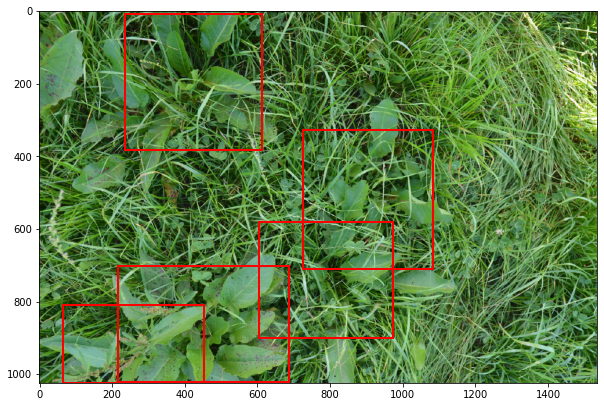

In [30]:
#Let's read and image and check if the bouding boxes are extracted correctly

# Choose an image
index = 19 #problem occurs from 1 to 7 (because annotations were skipped for these images)

#What is the image name for this index
list_image = [i for i in os.listdir(images_home) if i.endswith('png') or i.endswith('jpg') or i.endswith('PNG') or i.endswith('JPG') or i.endswith('JPEG')]
imname = list_image[index]
print(imname)
#Read image
plt.rcParams["figure.figsize"] = [10, 10]
fig, ax = plt.subplots()
im = Image.open(f'{images_home}/{imname}')
ax.imshow(im)

#Read bboxes of that specific image
bboxes = get_bboxes(df, imname)
print(bboxes)
# Create a Rectangle patch
for bbox in bboxes:
    xmin, ymin, xmax, ymax = bbox[0], bbox[1], bbox[2], bbox[3]
    #https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Rectangle.html
    rect = Rectangle((xmin, ymax), xmax - xmin, ymin - ymax, linewidth=2, edgecolor='r', facecolor='none')
    # We put ymin - ymax because the coordinates of the image are inverted (check documentation)
    # Add the patch to the Axes
    ax.add_patch(rect)
    
    

#Show image with bouding boxes
plt.show()
#[xmin, ymin, xmax, ymax]

In [9]:
def preprocess_image(img):
    img = np.array(img) / 255.
    img = torch.tensor(img).permute(2,0,1)  #
    #
    return img.to(device).float()

In [95]:
#The image as read by the PIL 
img = Image.open(f'{images_home}/{imname}').convert("RGB")
print(type(img))
#print(np.array(img).shape) #No shape function for the PIL.Image.Image
#show(img)
#Then after transforming it to array
img = np.array(img) / 255.
#show(img) #We can't divide the PIL by 255. We have to transform it to an array first
#print(np.array(img).shape) #No shape function for the PIL.Image.Image
#
img = torch.tensor(img).permute(2,0,1)  #
print(img)

#show(img)
#print(np.array(img).shape) #No shape function for the PIL.Image.Image

#Making putting the image on CUDA and transforming it to float
img.to(device).float()

<class 'PIL.Image.Image'>

tensor([[[0.3686, 0.3686, 0.3725,  ..., 0.2078, 0.2157, 0.2510],
         [0.3961, 0.3961, 0.3961,  ..., 0.1216, 0.1882, 0.2471],
         [0.4039, 0.4039, 0.4039,  ..., 0.1333, 0.2275, 0.2471],
         ...,
         [0.2039, 0.1294, 0.1294,  ..., 0.1843, 0.1647, 0.1569],
         [0.0941, 0.0980, 0.1294,  ..., 0.2000, 0.1686, 0.1451],
         [0.1020, 0.1255, 0.1176,  ..., 0.2000, 0.1961, 0.1686]],

        [[0.5608, 0.5608, 0.5647,  ..., 0.4078, 0.4039, 0.4314],
         [0.5922, 0.5922, 0.5922,  ..., 0.3255, 0.3804, 0.4314],
         [0.6039, 0.6039, 0.6039,  ..., 0.3373, 0.4235, 0.4353],
         ...,
         [0.3765, 0.3059, 0.3137,  ..., 0.4118, 0.4039, 0.4000],
         [0.2706, 0.2784, 0.3098,  ..., 0.4235, 0.4196, 0.4000],
         [0.2863, 0.3059, 0.3020,  ..., 0.4235, 0.4549, 0.4392]],

        [[0.3412, 0.3412, 0.3451,  ..., 0.1059, 0.0745, 0.0863],
         [0.3529, 0.3529, 0.3529,  ..., 0.0157, 0.0275, 0.0667],
         [0.3412, 0.3412, 0.3412,  ..., 0.0039, 0.0392, 0.0431],
         ...,
         [0.1608, 0.0627, 0.0314,  ..., 0.0824, 0.0471, 0.0314],
         [0.0118, 0.0039, 0.0157,  ..., 0.0941, 0.0549, 0.0314],
         [0.0039, 0.0078, 0.0039,  ..., 0.0902, 0.0902, 0.0627]]],
       dtype=torch.float64)

tensor([[[0.3686, 0.3686, 0.3725,  ..., 0.2078, 0.2157, 0.2510],
         [0.3961, 0.3961, 0.3961,  ..., 0.1216, 0.1882, 0.2471],
         [0.4039, 0.4039, 0.4039,  ..., 0.1333, 0.2275, 0.2471],
         ...,
         [0.2039, 0.1294, 0.1294,  ..., 0.1843, 0.1647, 0.1569],
         [0.0941, 0.0980, 0.1294,  ..., 0.2000, 0.1686, 0.1451],
         [0.1020, 0.1255, 0.1176,  ..., 0.2000, 0.1961, 0.1686]],

        [[0.5608, 0.5608, 0.5647,  ..., 0.4078, 0.4039, 0.4314],
         [0.5922, 0.5922, 0.5922,  ..., 0.3255, 0.3804, 0.4314],
         [0.6039, 0.6039, 0.6039,  ..., 0.3373, 0.4235, 0.4353],
         ...,
         [0.3765, 0.3059, 0.3137,  ..., 0.4118, 0.4039, 0.4000],
         [0.2706, 0.2784, 0.3098,  ..., 0.4235, 0.4196, 0.4000],
         [0.2863, 0.3059, 0.3020,  ..., 0.4235, 0.4549, 0.4392]],

        [[0.3412, 0.3412, 0.3451,  ..., 0.1059, 0.0745, 0.0863],
         [0.3529, 0.3529, 0.3529,  ..., 0.0157, 0.0275, 0.0667],
         [0.3412, 0.3412, 0.3412,  ..., 0.0039, 0.0392, 0.

# Creating the dataset
Creating dataset (and dataloaders) are the most important steps in the training pipeline. Pytorch (also other platforms) have standarised ways to created data sets. This is because data and annotations comes in different format, but the models accepts them in a standard format only. 
- Simple data sets could be created by overriding the ```torch.utils.data.Dataset``` class.
- Vision data sets could be created by overriding the ```torchvision.datasets.VisionDataset``` class. This class is more aligned toward where annotations such as bounding boxes, semantic segments and key points are used.
 
Two methods should be overrided:
- The ```__getitem__ ``` method: in this method, we return the image ```i``` with it bounding box or mask
- The ```__len__``` method: in this method we return the number of images in the dataset


In [10]:
#Define the Rumex Dataset

class RumexDataSetLabelBox(Dataset):
    def __init__(self, root, annotations_csv, transforms = None):
        
        self.root = root
        self.list_image = list(annotations_csv['External ID'])
        #print(self.list_image)
        self.datalength = len(self.list_image)
        self.transforms = transforms
   
    def __getitem__(self, index):
        #This should return a tuple containing: the image in tensor format and the list of bounding boxes in the image
        # Given an index, we should be able to read the image from the root folder and its corresponding Bboxes
        #Bboxes should be in the following format [xmin, ymin, xmax, ymax]

        imname = self.list_image[index]
        img_path = os.path.join(self.root, imname) 
        img = Image.open(img_path).convert("RGB")

        bboxes = get_bboxes(annotations_csv, imname)
        
        image_id = torch.tensor([index])
        #area = [ (b[3] - b[1]) * (b[2] - b[0]) for b in bboxes]

        num_rumex = len(bboxes)
        labels = torch.ones((num_rumex,), dtype=torch.int64) #Target labels should be of type int64
        target = {}
        

        target["boxes"] = torch.Tensor(bboxes)
        target["labels"] =  labels
        #target["image_id"] = image_id
        #target["area"] = torch.Tensor(area)

        img = preprocess_image(img)
        #if self.transforms is not None:
        #    img, target = self.transforms(img, target)


        return img, target

    def __len__(self):
        return self.datalength



In [11]:
annotations_csv = load_clean_annotations()
rumex_dataset = RumexDataSetLabelBox(images_home, annotations_csv)

sample_data = rumex_dataset[1]
sample_data[1], sample_data[0]

({'boxes': tensor([[ 493.,  400.,  856.,  612.],
          [ 386.,  203.,  765.,  568.],
          [ 301.,  548.,  522.,  750.],
          [ 327.,  267.,  513.,  420.],
          [ 823.,   31., 1056.,  220.],
          [ 183.,  134.,  505.,  383.],
          [ 690.,  525., 1103.,  730.],
          [ 516.,  330.,  928.,  566.],
          [  75.,  475.,  284.,  720.],
          [ 236.,  868.,  537., 1023.],
          [ 117.,   23.,  559.,  207.],
          [ 495.,    0.,  678.,   99.]]),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])},
 tensor([[[0.2078, 0.2118, 0.1961,  ..., 0.3569, 0.3255, 0.3961],
          [0.1137, 0.2039, 0.2000,  ..., 0.3176, 0.3608, 0.6039],
          [0.0745, 0.1216, 0.1922,  ..., 0.2980, 0.5529, 0.8275],
          ...,
          [0.3569, 0.3529, 0.3294,  ..., 0.2706, 0.2706, 0.2627],
          [0.3569, 0.3490, 0.3294,  ..., 0.2980, 0.2980, 0.2902],
          [0.3569, 0.3529, 0.3255,  ..., 0.2667, 0.2667, 0.2588]],
 
         [[0.3765, 0.3843, 0.3804,  

In [12]:
#Reference
#https://debuggercafe.com/custom-object-detection-using-pytorch-faster-rcnn/

def collate_fn(batch):
    """
    To handle the data loading as different images may have different number 
    of objects and to handle varying size tensors as well.
    """
    return tuple(zip(*batch))

    #About ZIP:
    #It 'zips' tupples so that we can iterate over them in parallel (https://docs.python.org/3/library/functions.html#zip)
    #The two iterables in our case are: target and features
    #This is necessary because not all targets have the same size (same # of bboxes)
    #We give collate as an argument to the dataloader to tell DataLoader how to collate the feature/targets 
    #Together.  

# define the training tranforms
def get_train_transform():
    return transforms.Compose([
        transforms.Flip(0.5),
        transforms.RandomRotate90(0.5),
        transforms.ToTensor(),
    ], bbox_params={
        'format': 'pascal_voc',
        'label_fields': ['labels']
    })

# define the validation transforms
def get_valid_transform():
    return transforms.Compose([
        transforms.ToTensor(),
    ], bbox_params={
        'format': 'pascal_voc', 
        'label_fields': ['labels']
    })


def show_tranformed_image(train_loader):
    """
    This function shows the transformed images from the `train_loader`.
    Helps to check whether the tranformed images along with the corresponding
    labels are correct or not.
    Only runs if `VISUALIZE_TRANSFORMED_IMAGES = True` in config.py.
    """
    if len(train_loader) > 0:
        for i in range(1):
            images, targets = next(iter(train_loader))
            images = list(image.to(DEVICE) for image in images)
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
            boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
            labels = targets[i]['labels'].cpu().numpy().astype(np.int32)
            sample = images[i].permute(1, 2, 0).cpu().numpy()
            for box_num, box in enumerate(boxes):
                cv2.rectangle(sample,
                            (box[0], box[1]),
                            (box[2], box[3]),
                            (0, 0, 255), 2)
                cv2.putText(sample, CLASSES[labels[box_num]], 
                            (box[0], box[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 
                            1.0, (0, 0, 255), 2)
            cv2.imshow('Transformed image', sample)
            cv2.waitKey(0)
            cv2.destroyAllWindows()

def save_model(epoch, model, optimizer):
    """
    Function to save the trained model till current epoch, or whenver called
    """
    torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, 'outputs/last_model.pth')

def save_loss_plot(OUT_DIR, train_loss, val_loss):
    figure_1, train_ax = plt.subplots()
    figure_2, valid_ax = plt.subplots()
    train_ax.plot(train_loss, color='tab:blue')
    train_ax.set_xlabel('iterations')
    train_ax.set_ylabel('train loss')
    valid_ax.plot(val_loss, color='tab:red')
    valid_ax.set_xlabel('iterations')
    valid_ax.set_ylabel('validation loss')
    figure_1.savefig(f"{OUT_DIR}/train_loss.png")
    figure_2.savefig(f"{OUT_DIR}/valid_loss.png")
    print('SAVING PLOTS COMPLETE...')

    plt.close('all')


# Creating datasets and Dataloaders
 
We can either create 3 separete datasets (training, testing and validation) or create one dataset and then split 
it afterward. I prefer to create one dataset and then split it afterwards. This will help randomizing the experiments at each run.


In [99]:
sample_data[0]

tensor([[[0.2078, 0.2118, 0.1961,  ..., 0.3569, 0.3255, 0.3961],
         [0.1137, 0.2039, 0.2000,  ..., 0.3176, 0.3608, 0.6039],
         [0.0745, 0.1216, 0.1922,  ..., 0.2980, 0.5529, 0.8275],
         ...,
         [0.3569, 0.3529, 0.3294,  ..., 0.2706, 0.2706, 0.2627],
         [0.3569, 0.3490, 0.3294,  ..., 0.2980, 0.2980, 0.2902],
         [0.3569, 0.3529, 0.3255,  ..., 0.2667, 0.2667, 0.2588]],

        [[0.3765, 0.3843, 0.3804,  ..., 0.6157, 0.5451, 0.6000],
         [0.2745, 0.3725, 0.3804,  ..., 0.5569, 0.5647, 0.7961],
         [0.2314, 0.2863, 0.3725,  ..., 0.5137, 0.7294, 0.9765],
         ...,
         [0.5176, 0.5137, 0.4902,  ..., 0.4118, 0.4118, 0.4039],
         [0.5020, 0.4941, 0.4667,  ..., 0.4667, 0.4667, 0.4588],
         [0.4745, 0.4667, 0.4353,  ..., 0.4745, 0.4745, 0.4667]],

        [[0.0706, 0.0824, 0.0824,  ..., 0.1412, 0.0510, 0.1020],
         [0.0157, 0.0902, 0.0863,  ..., 0.0902, 0.0784, 0.3020],
         [0.0039, 0.0353, 0.0863,  ..., 0.0510, 0.2471, 0.

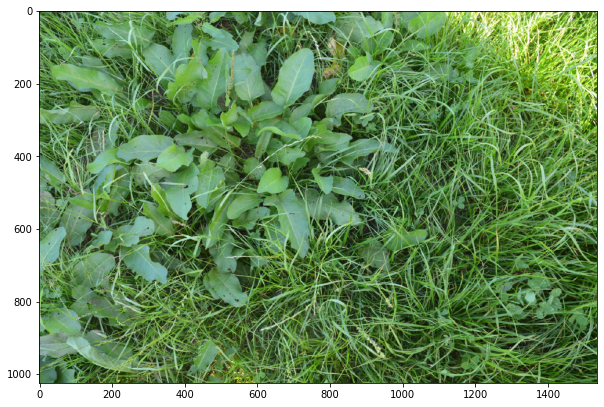

In [101]:
plt.imshow(sample_data[0].cpu().permute(1,2,0))

In [23]:
sample_data[0].shape

torch.Size([3, 1024, 1536])

In [24]:
sample_data[1]

{'boxes': tensor([[ 493.,  400.,  856.,  612.],
         [ 386.,  203.,  765.,  568.],
         [ 301.,  548.,  522.,  750.],
         [ 327.,  267.,  513.,  420.],
         [ 823.,   31., 1056.,  220.],
         [ 183.,  134.,  505.,  383.],
         [ 690.,  525., 1103.,  730.],
         [ 516.,  330.,  928.,  566.],
         [  75.,  475.,  284.,  720.],
         [ 236.,  868.,  537., 1023.],
         [ 117.,   23.,  559.,  207.],
         [ 495.,    0.,  678.,   99.]]),
 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])}

# Split dataset from here
https://stackoverflow.com/questions/50544730/how-do-i-split-a-custom-dataset-into-training-and-test-datasets/50544887#50544887

In [13]:
n_datapoints = len(rumex_dataset)
n_train = int(0.7 * n_datapoints)
n_test =  int(0.15 * n_datapoints)
n_val = n_datapoints - n_train - n_test #Try int(0.15 * n_datapoints) and see what happens
train_data, test_data, val_data = random_split(rumex_dataset, [n_train, n_test, n_val])

#In some situation, you might need to create each datasets separately rather than deriving them from the main dataset. This happens when data are 
#already splited into train/test/val folders and annotations also splitted.

In [14]:
print(f'Number of images in the training dataset is: {len(train_data)}')
print(f'Number of images in the training dataset is: {len(test_data)}')
print(f'Number of images in the training dataset is: {len(val_data)}')

Number of images in the training dataset is: 329

Number of images in the training dataset is: 70

Number of images in the training dataset is: 72

# Dataloaders
Iterable wrappers around the datasets

In [15]:
train_loader = DataLoader(
        train_data,
        batch_size=8,
        shuffle=False,
        collate_fn=collate_fn
    )
test_loader = DataLoader(
    test_data,
    batch_size=8,
    shuffle=False,
    collate_fn=collate_fn
)
val_loader = DataLoader(
        val_data,
        batch_size=8,
        shuffle=False,
        collate_fn=collate_fn
    )

#train_loader = DataLoader(train_ds, batch_size=4, collate_fn=train_ds.collate_fn, drop_last=True)


In [90]:
a_sample = next(iter(train_loader))

In [91]:
a_sample[0][0]

tensor([[[0.2667, 0.2667, 0.2706,  ..., 0.1569, 0.1529, 0.1490],
         [0.2863, 0.2863, 0.2863,  ..., 0.1725, 0.1882, 0.2039],
         [0.3059, 0.3059, 0.3059,  ..., 0.2118, 0.2431, 0.2392],
         ...,
         [0.1451, 0.1294, 0.1176,  ..., 0.3882, 0.4510, 0.5020],
         [0.1451, 0.1333, 0.1255,  ..., 0.2431, 0.3059, 0.3569],
         [0.1412, 0.1451, 0.1451,  ..., 0.1686, 0.2078, 0.2745]],

        [[0.4235, 0.4235, 0.4275,  ..., 0.3137, 0.3176, 0.3176],
         [0.4431, 0.4431, 0.4431,  ..., 0.3294, 0.3529, 0.3765],
         [0.4627, 0.4627, 0.4627,  ..., 0.3725, 0.4118, 0.4157],
         ...,
         [0.2588, 0.2431, 0.2275,  ..., 0.5176, 0.5882, 0.6431],
         [0.2549, 0.2431, 0.2353,  ..., 0.3569, 0.4314, 0.4824],
         [0.2510, 0.2549, 0.2510,  ..., 0.2667, 0.3176, 0.3882]],

        [[0.3216, 0.3216, 0.3255,  ..., 0.1059, 0.0980, 0.0980],
         [0.3412, 0.3412, 0.3412,  ..., 0.1059, 0.1176, 0.1412],
         [0.3608, 0.3608, 0.3608,  ..., 0.1255, 0.1529, 0.

# Modelling (Defining the model / Model inspection)

In [30]:
#Model fastrcnn
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model

/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [31]:
type(model.transform)

torchvision.models.detection.transform.GeneralizedRCNNTransform

In [32]:
#We can access each layer from the pre-built model as follow model.<layer_name>
model.roi_heads

RoIHeads(
  (box_roi_pool): MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(7, 7), sampling_ratio=2)
  (box_head): TwoMLPHead(
    (fc6): Linear(in_features=12544, out_features=1024, bias=True)
    (fc7): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (box_predictor): FastRCNNPredictor(
    (cls_score): Linear(in_features=1024, out_features=91, bias=True)
    (bbox_pred): Linear(in_features=1024, out_features=364, bias=True)
  )
)

In [33]:
#We can access each sublayer (... and sub sub layer) from the pre-built model as follow model.<layer_name>.<sub_layer_name>
model.roi_heads.box_roi_pool

MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(7, 7), sampling_ratio=2)

This model was created to predict 91 class of object and their corresponding bounding boxes 91*4 = 364
```
    (box_predictor): FastRCNNPredictor(
      (cls_score): Linear(in_features=1024, out_features=91, bias=True)
      (bbox_pred): Linear(in_features=1024, out_features=364, bias=True)
```
We need to change the model so that it is able to localize our ```n_classes```. In our case, we have background and Rumex. So, 2 classes.

This is possible by creating replacing the whole (can't we only replace the last layer??)

In [34]:
# get the number of input features 
in_features = model.roi_heads.box_predictor.cls_score.in_features

# define a new head for the detector with required number of classes
num_classes = 2
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

#Question: Why can't we change directly the output_features like this: model.roi_heads.box_predictor.cls_score.out_features = 4
#Answer: because this will not change the output features of the bbox pred. Therefore, we need to change both (cls_score and bbox_pred score) 
#Separately. It's a good habit to replace the whole block rather than fixing only one part to avoid possible errors

In [35]:
model.roi_heads.box_predictor

FastRCNNPredictor(
  (cls_score): Linear(in_features=1024, out_features=2, bias=True)
  (bbox_pred): Linear(in_features=1024, out_features=8, bias=True)
)

In [36]:
#Model parameters is an iterable around the model parameters
next(model.parameters()).numel()

9408

In [37]:
#Printing trainable layers
for layer in model.parameters():
    if layer.requires_grad:
        print(layer.shape)

torch.Size([128, 256, 1, 1])

torch.Size([128, 128, 3, 3])

torch.Size([512, 128, 1, 1])

torch.Size([512, 256, 1, 1])

torch.Size([128, 512, 1, 1])

torch.Size([128, 128, 3, 3])

torch.Size([512, 128, 1, 1])

torch.Size([128, 512, 1, 1])

torch.Size([128, 128, 3, 3])

torch.Size([512, 128, 1, 1])

torch.Size([128, 512, 1, 1])

torch.Size([128, 128, 3, 3])

torch.Size([512, 128, 1, 1])

torch.Size([256, 512, 1, 1])

torch.Size([256, 256, 3, 3])

torch.Size([1024, 256, 1, 1])

torch.Size([1024, 512, 1, 1])

torch.Size([256, 1024, 1, 1])

torch.Size([256, 256, 3, 3])

torch.Size([1024, 256, 1, 1])

torch.Size([256, 1024, 1, 1])

torch.Size([256, 256, 3, 3])

torch.Size([1024, 256, 1, 1])

torch.Size([256, 1024, 1, 1])

torch.Size([256, 256, 3, 3])

torch.Size([1024, 256, 1, 1])

torch.Size([256, 1024, 1, 1])

torch.Size([256, 256, 3, 3])

torch.Size([1024, 256, 1, 1])

torch.Size([256, 1024, 1, 1])

torch.Size([256, 256, 3, 3])

torch.Size([1024, 256, 1, 1])

torch.Size([512, 1024, 1, 1])

torch.Size([512, 512, 3, 3])

torch.Size([2048, 512, 1, 1])

torch.Size([2048, 1024, 1, 1])

torch.Size([512, 2048, 1, 1])

torch.Size([512, 512, 3, 3])

torch.Size([2048, 512, 1, 1])

torch.Size([512, 2048, 1, 1])

torch.Size([512, 512, 3, 3])

torch.Size([2048, 512, 1, 1])

torch.Size([256, 256, 1, 1])

torch.Size([256])

torch.Size([256, 512, 1, 1])

torch.Size([256])

torch.Size([256, 1024, 1, 1])

torch.Size([256])

torch.Size([256, 2048, 1, 1])

torch.Size([256])

torch.Size([256, 256, 3, 3])

torch.Size([256])

torch.Size([256, 256, 3, 3])

torch.Size([256])

torch.Size([256, 256, 3, 3])

torch.Size([256])

torch.Size([256, 256, 3, 3])

torch.Size([256])

torch.Size([256, 256, 3, 3])

torch.Size([256])

torch.Size([3, 256, 1, 1])

torch.Size([3])

torch.Size([12, 256, 1, 1])

torch.Size([12])

torch.Size([1024, 12544])

torch.Size([1024])

torch.Size([1024, 1024])

torch.Size([1024])

torch.Size([2, 1024])

torch.Size([2])

torch.Size([8, 1024])

torch.Size([8])

In [38]:
#Printing non trainable layers
for layer in model.parameters():
    if not layer.requires_grad:
        print(layer.shape)

torch.Size([64, 3, 7, 7])

torch.Size([64, 64, 1, 1])

torch.Size([64, 64, 3, 3])

torch.Size([256, 64, 1, 1])

torch.Size([256, 64, 1, 1])

torch.Size([64, 256, 1, 1])

torch.Size([64, 64, 3, 3])

torch.Size([256, 64, 1, 1])

torch.Size([64, 256, 1, 1])

torch.Size([64, 64, 3, 3])

torch.Size([256, 64, 1, 1])

In [39]:
#Counting the number of all model parameters
total_params = sum(
	param.numel() for param in model.parameters()
)

#Counting the number of trainable parameters
trainable_params = sum(
	p.numel() for p in model.parameters() if p.requires_grad
)



In [40]:
print(f'There are {total_params} parameters in the model, {trainable_params} of them are trainable and {total_params - trainable_params} are not trainable')

There are 41299161 parameters in the model, 41076761 of them are trainable and 222400 are not trainable

# Modelling (Defining a generic function for the model)

In [16]:
def get_model(num_classes = 2):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [106]:
model = get_model(num_classes= 2)
model.roi_heads.box_predictor

/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FastRCNNPredictor(
  (cls_score): Linear(in_features=1024, out_features=2, bias=True)
  (bbox_pred): Linear(in_features=1024, out_features=8, bias=True)
)

# Modelling (Fitting the model)

In [43]:
# Defining training and validation functions for a single batch
def train_batch(inputs, model, optimizer):
    model.train()
    input, targets = inputs
    input = list(image.to(device) for image in input)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    optimizer.zero_grad()
    losses = model(input, targets)
    loss = sum(loss for loss in losses.values())
    loss.backward()
    optimizer.step()
    return loss, losses

@torch.no_grad() # this will disable gradient computation in the function below
def validate_batch(inputs, model):
    model.train() # to obtain the losses, model needs to be in train mode only. # #Note that here we are not defining the model's forward method 
#and hence need to work per the way the model class is defined
    input, targets = inputs
    input = list(image.to(device) for image in input)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    optimizer.zero_grad()
    losses = model(input, targets)
    loss = sum(loss for loss in losses.values())
    return loss, losses

In [44]:
model = get_model().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
n_epochs = 5
log = Report(n_epochs) #From pytorch_snipets


In [46]:
for epoch in range(n_epochs):
    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        loss, losses = train_batch(inputs, model, optimizer)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = \
            [losses[k] for k in ['loss_classifier','loss_box_reg','loss_objectness','loss_rpn_box_reg']]
        pos = (epoch + (ix+1)/_n)
        
        log.record(pos, trn_loss=loss.item(), trn_loc_loss=loc_loss.item(), 
                   trn_regr_loss=regr_loss.item(), trn_objectness_loss=loss_objectness.item(),
                   trn_rpn_box_reg_loss=loss_rpn_box_reg.item(), end='\r')
        

    _n = len(test_loader)
    for ix,inputs in enumerate(test_loader):
        loss, losses = validate_batch(inputs, model)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = \
          [losses[k] for k in ['loss_classifier','loss_box_reg','loss_objectness','loss_rpn_box_reg']]
        pos = (epoch + (ix+1)/_n)
        
        log.record(pos, val_loss=loss.item(), val_loc_loss=loc_loss.item(), 
                  val_regr_loss=regr_loss.item(), val_objectness_loss=loss_objectness.item(),
                  val_rpn_box_reg_loss=loss_rpn_box_reg.item(), end='\r')
        
    if (epoch+1)%(n_epochs//5)==0: log.report_avgs(epoch+1)

EPOCH: 1.000  val_objectness_loss: 0.040  val_loss: 0.548  trn_rpn_box_reg_loss: 0.013  trn_regr_loss: 0.235  trn_objectness_loss: 0.059  val_loc_loss: 0.193  trn_loss: 0.497  val_rpn_box_reg_loss: 0.013  val_regr_loss: 0.302  trn_loc_loss: 0.190  (163.91s - 655.65s remaining)
EPOCH: 2.000  val_objectness_loss: 0.034  val_loss: 0.491  trn_rpn_box_reg_loss: 0.010  trn_regr_loss: 0.252  trn_objectness_loss: 0.027  val_loc_loss: 0.174  trn_loss: 0.454  val_rpn_box_reg_loss: 0.013  val_regr_loss: 0.270  trn_loc_loss: 0.165  (329.35s - 494.02s remaining)
EPOCH: 3.000  val_objectness_loss: 0.037  val_loss: 0.478  trn_rpn_box_reg_loss: 0.009  trn_regr_loss: 0.231  trn_objectness_loss: 0.016  val_loc_loss: 0.168  trn_loss: 0.394  val_rpn_box_reg_loss: 0.012  val_regr_loss: 0.261  trn_loc_loss: 0.138  (493.79s - 329.19s remaining)
EPOCH: 4.000  val_objectness_loss: 0.035  val_loss: 0.490  trn_rpn_box_reg_loss: 0.008  trn_regr_loss: 0.209  trn_objectness_loss: 0.011  val_loc_loss: 0.176  trn_los

100%|██████████| 106/106 [00:00<00:00, 18113.51it/s]


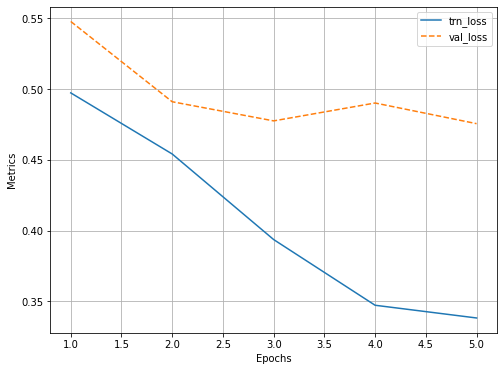

In [47]:
#Model loss evolution with epochs
log.plot_epochs(['trn_loss','val_loss'])

In [25]:
#Check the model with test images
from torchvision.ops import nms
def decode_output(output):
    'convert tensors to numpy arrays'
    bbs = output['boxes'].cpu().detach().numpy().astype(np.uint16)
    labels = np.array(output['labels'].cpu().detach().numpy())
    confs = output['scores'].cpu().detach().numpy()
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    bbs, confs, labels = [tensor[ixs] for tensor in [bbs, confs, labels]]

    if len(ixs) == 1:
        bbs, confs, labels = [np.array([tensor]) for tensor in [bbs, confs, labels]]
    return bbs.tolist(), confs.tolist(), labels.tolist()



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


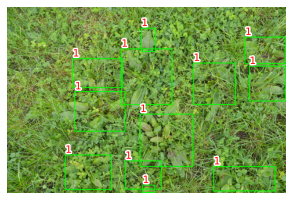

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


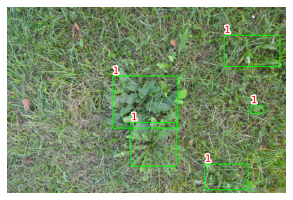

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


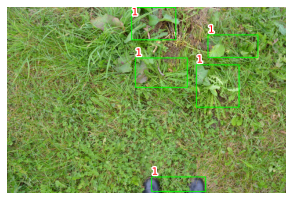

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


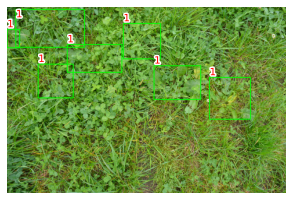

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


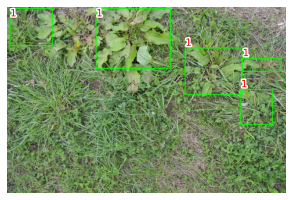

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


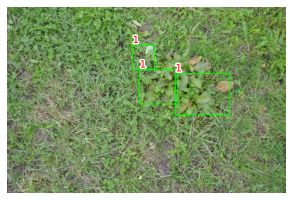

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


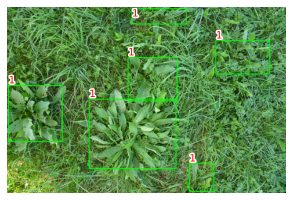

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


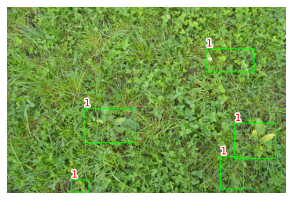

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


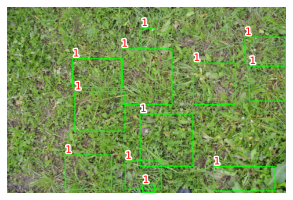

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


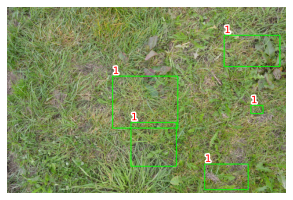

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


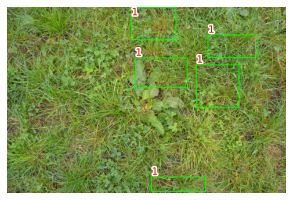

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


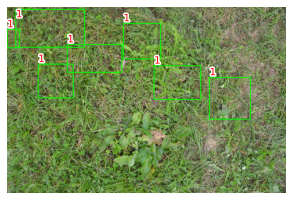

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


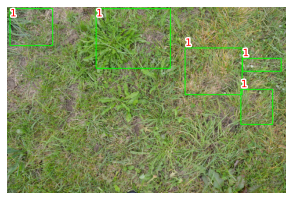

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


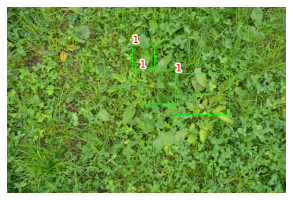

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


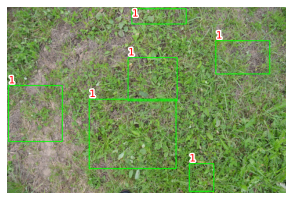

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


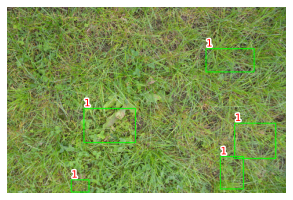

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


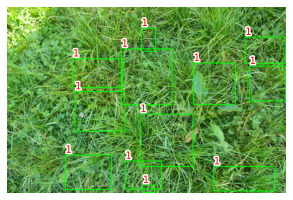

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


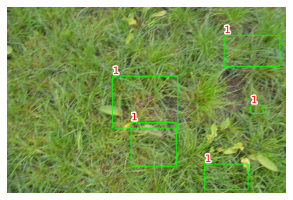

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


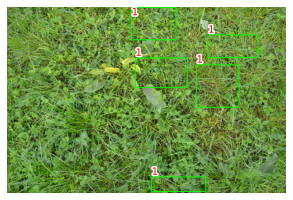

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


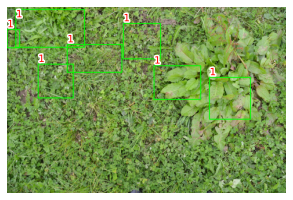

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


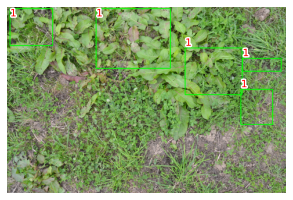

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


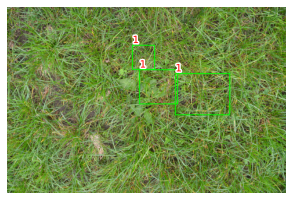

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


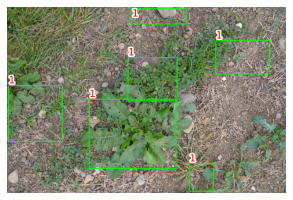

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


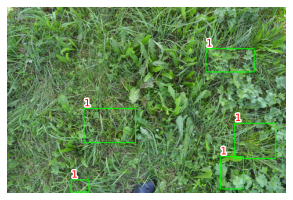

In [81]:
model.eval()
for ix, (images, targets) in enumerate(test_loader):
    if ix==3: break
    images = [im for im in images]
    #outputs = model(images)
    
    for ix, output in enumerate(outputs):
        bbs, confs, labels = decode_output(output)
        #print(bbs)
        #print(confs)
        #print(labels)
        #info = [f'{l}@{c:.2f}' for l,c in zip(labels, confs)]
        show(images[ix].cpu().permute(1,2,0), bbs=bbs, texts=labels, sz=5) #Show from pytorch snippets

# Saving the model in pth format

In [ ]:
torch.save(model.state_dict(), "model/model.pth")
print("Saved PyTorch Model State to model.pth")

# Reading the pth model and making inference with it

In [17]:
model = get_model(num_classes= 2).to(device)
model.load_state_dict(torch.load("model/model.pth"))

/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

[
    tensor([[[0.3647, 0.3765, 0.3882,  ..., 0.2706, 0.3255, 0.3098],
         [0.3569, 0.3725, 0.3843,  ..., 0.2431, 0.3059, 0.3176],
         [0.3529, 0.3647, 0.3765,  ..., 0.2706, 0.2902, 0.2863],
         ...,
         [0.4353, 0.4314, 0.4235,  ..., 0.4667, 0.4745, 0.4706],
         [0.4275, 0.4196, 0.4157,  ..., 0.4706, 0.4784, 0.4706],
         [0.4196, 0.4118, 0.4078,  ..., 0.4706, 0.4784, 0.4706]],

        [[0.5765, 0.5882, 0.6000,  ..., 0.3490, 0.4392, 0.4353],
         [0.5686, 0.5843, 0.5961,  ..., 0.3412, 0.4353, 0.4627],
         [0.5647, 0.5765, 0.5882,  ..., 0.3843, 0.4392, 0.4510],
         ...,
         [0.5882, 0.5843, 0.5804,  ..., 0.6314, 0.6392, 0.6353],
         [0.5882, 0.5804, 0.5765,  ..., 0.6353, 0.6431, 0.6353],
         [0.5804, 0.5725, 0.5686,  ..., 0.6353, 0.6431, 0.6353]],

        [[0.1412, 0.1529, 0.1647,  ..., 0.2078, 0.2588, 0.2392],
         [0.1333, 0.1490, 0.1608,  ..., 0.1961, 0.2431, 0.2588],
         [0.1294, 0.1412, 0.1529,  ..., 0.2314, 0.2471, 0.2392],
         ...,
         [0.3255, 0.3216, 0.3137,  ..., 0.3529, 0.3529, 0.3412],
         [0.3137, 0.3059, 0.3020,  ..., 0.3529, 0.3490, 0.3373],
         [0.3059, 0.2980, 0.2941,  ..., 0.3529, 0.3490, 0.3373]]],
       device='cuda:0'),
    tensor([[[0.3176, 0.3176, 0.3294,  ..., 0.2157, 0.2510, 0.2667],
         [0.2980, 0.3098, 0.3255,  ..., 0.2157, 0.2784, 0.2980],
         [0.3059, 0.3137, 0.3294,  ..., 0.2471, 0.3098, 0.3294],
         ...,
         [0.3059, 0.2745, 0.2941,  ..., 0.2863, 0.3098, 0.3412],
         [0.2510, 0.2745, 0.3216,  ..., 0.2863, 0.3373, 0.3725],
         [0.2627, 0.3020, 0.3333,  ..., 0.3216, 0.3686, 0.3961]],

        [[0.2941, 0.2941, 0.3059,  ..., 0.2392, 0.2510, 0.2549],
         [0.2745, 0.2863, 0.3020,  ..., 0.2471, 0.2863, 0.3020],
         [0.2824, 0.2902, 0.3059,  ..., 0.2863, 0.3412, 0.3569],
         ...,
         [0.3961, 0.3647, 0.3804,  ..., 0.4510, 0.4784, 0.5098],
         [0.3412, 0.3647, 0.4118,  ..., 0.4431, 0.4941, 0.5255],
         [0.3569, 0.3961, 0.4275,  ..., 0.4627, 0.5098, 0.5373]],

        [[0.3020, 0.3020, 0.3137,  ..., 0.1216, 0.1294, 0.1333],
         [0.2824, 0.2941, 0.3098,  ..., 0.1255, 0.1647, 0.1765],
         [0.2902, 0.2980, 0.3137,  ..., 0.1647, 0.2078, 0.2235],
         ...,
         [0.2235, 0.1922, 0.2118,  ..., 0.2706, 0.2941, 0.3255],
         [0.1647, 0.1843, 0.2314,  ..., 0.2627, 0.3176, 0.3529],
         [0.1647, 0.2039, 0.2353,  ..., 0.2863, 0.3412, 0.3725]]],
       device='cuda:0'),
    tensor([[[0.2039, 0.1922, 0.1686,  ..., 0.2471, 0.2275, 0.2039],
         [0.2118, 0.1961, 0.1686,  ..., 0.2549, 0.2745, 0.2980],
         [0.2471, 0.2392, 0.2275,  ..., 0.2627, 0.2863, 0.3098],
         ...,
         [0.0902, 0.0863, 0.1647,  ..., 0.5294, 0.5255, 0.5216],
         [0.1647, 0.2118, 0.2627,  ..., 0.4627, 0.4627, 0.4627],
         [0.2667, 0.2510, 0.2549,  ..., 0.3647, 0.3608, 0.3608]],

        [[0.3490, 0.3373, 0.3020,  ..., 0.2706, 0.2510, 0.2275],
         [0.3569, 0.3373, 0.2941,  ..., 0.2627, 0.2824, 0.3098],
         [0.3843, 0.3765, 0.3529,  ..., 0.2510, 0.2784, 0.3020],
         ...,
         [0.1843, 0.1765, 0.2314,  ..., 0.5882, 0.5882, 0.5922],
         [0.2549, 0.2902, 0.3176,  ..., 0.5569, 0.5569, 0.5608],
         [0.3294, 0.3098, 0.2902,  ..., 0.4863, 0.4824, 0.4863]],

        [[0.1451, 0.1373, 0.1137,  ..., 0.2039, 0.2039, 0.1804],
         [0.1686, 0.1569, 0.1255,  ..., 0.2000, 0.2235, 0.2353],
         [0.2235, 0.2157, 0.2039,  ..., 0.1882, 0.1961, 0.2039],
         ...,
         [0.0706, 0.0588, 0.1098,  ..., 0.2667, 0.2588, 0.2510],
         [0.1216, 0.1569, 0.1765,  ..., 0.2353, 0.2235, 0.2196],
         [0.1843, 0.1647, 0.1294,  ..., 0.2510, 0.2392, 0.2353]]],
       device='cuda:0'),
    tensor([[[0.2392, 0.2275, 0.2000,  ..., 0.7020, 0.6039, 0.4824],
         [0.2667, 0.2510, 0.2157,  ..., 0.6588, 0.5490, 0.4980],
         [0.3255, 0.3098, 0.2627,  ..., 0.5294, 0.4627, 0.4627],
         ...,
         [0.4706, 0.4902, 0.5098,  ..., 0.47

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


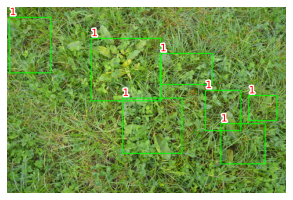

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


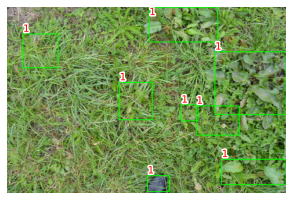

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


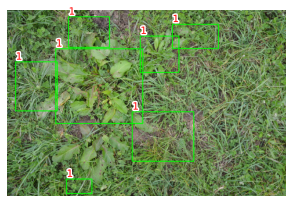

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


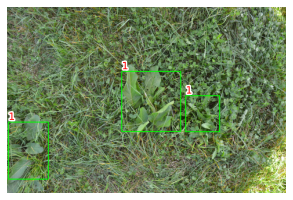

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


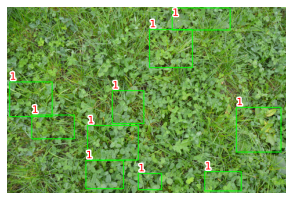

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


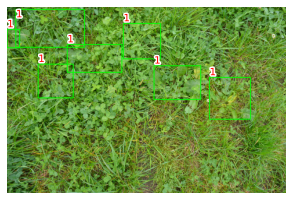

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


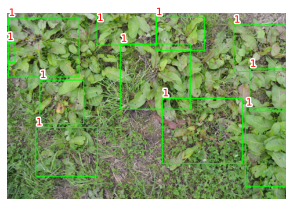

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


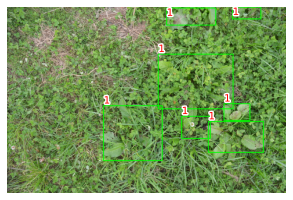

In [26]:
model.eval()
for ix, (images, targets) in enumerate(test_loader):
    if ix==1: break
    images = [im for im in images]
    print(images)
    with torch.no_grad():
        outputs = model(images)
    
    
    for ix, output in enumerate(outputs):
        bbs, confs, labels = decode_output(output)
        #print(bbs)
        #print(confs)
        #print(labels)
        #info = [f'{l}@{c:.2f}' for l,c in zip(labels, confs)]
        show(images[ix].cpu().permute(1,2,0), bbs=bbs, texts=labels, sz=5) #Show from pytorch snippets
    

In [27]:
import GPUtil
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 |  0% | 60% |
